In [ ]:
Kalp Yetmezliği Tahmini 
Amaç kalp yetmezliğine bağlı ölümleri tahmin etmek için belirlenen 12 değişken ile makina öğrenmesi algoritması geliştirmek.
Hedef Değişkeni > DEATH_EVENT (0: No , 1:Yes)
Değişkenler:
Yaş
Anemi
Kreatinin fosfokinaz
Diyabet (0:No , 1:Yes)
Ejeksiyon fraksiyonu
Yüksek tansiyon
Trombositler
Serum kreatinin
Serum sodyum
Cinsiyet (0: Kadın , 1: Erkek)
Sigara kullanımı
Zaman

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
#from catboost import CatBoostClassifier
import plotly.graph_objects as go
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


from warnings import filterwarnings
filterwarnings('ignore')



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="/content/drive/My Drive/Colab Notebooks/"
First_data=pd.read_csv(path+"heart_failure_clinical_records_dataset.csv")
data=First_data.copy()
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [ ]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


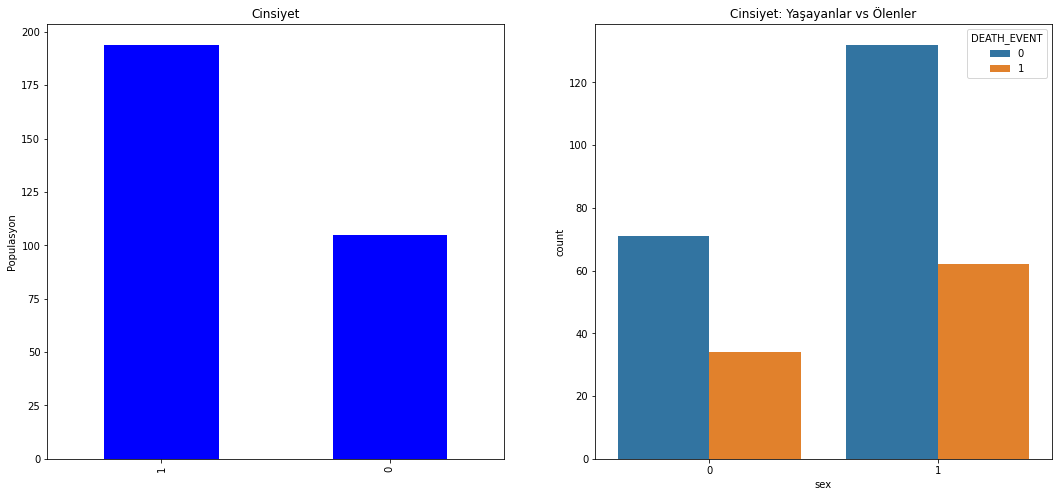

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))#subplot acılacak pencere sayısını gösterir
data["sex"].value_counts().plot.bar(color = "blue", ax = ax[0])
ax[0].set_title("Cinsiyet")
ax[0].set_ylabel("Populasyon")
sns.countplot("sex", hue = "DEATH_EVENT", data = data, ax = ax[1])
ax[1].set_title("Cinsiyet: Yaşayanlar vs Ölenler")
plt.show()

In [ ]:
death_sex=pd.crosstab(index=data['DEATH_EVENT'], columns=data["sex"])
print(death_sex)
# 105 kadın içerisinden ölüm olayı gerçekleşen kadın sayısı 34'tür.

sex           0    1
DEATH_EVENT         
0            71  132
1            34   62


In [ ]:
cross=pd.crosstab(index=data['DEATH_EVENT'], columns=data["sex"],normalize='index')

cross.index=["death_0","death_1"]
cross
# Cinsiyeti kadın olup yaşam olayı devam edenlerin oranı  tüm yaşayanların(Kadın+Erkek yaşayan) %34'ini oluşturmaktadır.
# Cinsiyeti kadın olup ölüm olayı gerçekleşenlerin oranı tüm ölüm olaylarının %35'ini oluşturmaktadır.
# Cinsiyeti erkek olup yaşayanlar tüm yaşayanların %65'ini oluşturmaktadır.
# Cinsiyeti erkek olup ölüm olayı  gerçekleşenlerin oranı tüm ölüm olaylarının %64'ünü oluşturmaktadır.

sex,0,1
death_0,0.349754,0.650246
death_1,0.354167,0.645833


In [ ]:
male = data[data["sex"]==1]
female = data[data["sex"]==0]

male_survi = male[data["DEATH_EVENT"]==0]
male_not = male[data["DEATH_EVENT"]==1]
female_survi = female[data["DEATH_EVENT"]==0]
female_not = female[data["DEATH_EVENT"]==1]

labels = ['Male - Survived','Male - Not Survived', "Female -  Survived", "Female - Not Survived"]
values = [len(male[data["DEATH_EVENT"]==0]),len(male[data["DEATH_EVENT"]==1]),
         len(female[data["DEATH_EVENT"]==0]),len(female[data["DEATH_EVENT"]==1])]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(
    title_text="Analysis on Survival - Gender")
fig.show()

In [ ]:
cross=pd.crosstab(index=data['DEATH_EVENT'], columns=data["diabetes"],normalize='index')

cross.index=["death_0","death_1"]
cross
# Diyabet hastalığı bulunup ölüm olayı gerçekleşme oranı tüm ölüm olaylarının içinde %41'dir.
# Diyabet hastalığı bulunmayıp ölüm olayı gerçekleşme oranı tüm ölüm olaylarının içinde yaklaşık %59'dur.

diabetes,0,1
death_0,0.581281,0.418719
death_1,0.583333,0.416667


In [ ]:
death_diabetes=pd.crosstab(index=data['DEATH_EVENT'], columns=data["diabetes"])
print(death_diabetes)

diabetes       0   1
DEATH_EVENT         
0            118  85
1             56  40


In [ ]:
diabetes_yes = data[data["diabetes"]==1]
diabetes_no = data[data["diabetes"]==0]

diabet_survi = data["DEATH_EVENT"]==0
diabet_not = data["DEATH_EVENT"]==1


labels = ['Diabetes_Yes - Survived','Diabetes_Yes - Not Survived','Diabetes_No - Survived','Diabetes_No - Not Survived']
values = [len(diabetes_yes[data["DEATH_EVENT"]==0]),len(diabetes_yes[data["DEATH_EVENT"]==1]),
          len(diabetes_no[data["DEATH_EVENT"]==0]),len(diabetes_no[data["DEATH_EVENT"]==1])]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(
    title_text="Analysis on Survival - Diabetes")
fig.show()

# 299 kişi içinde diyabet hastalığı olup yaşayanlar verinin %28'ini oluşturmaktadır. 
# 299 kişi içinde diyabet hastalığı olup ölenler verinin %13'ünü oluşturmaktadır.
# 299 kişi içinde diyabet hastalığı olmayıp yaşayanlar verinin %39.5'ini oluşturmaktadır.  
# 299 kişi içinde diyabet hastalığı olmayıp ölenler verinin %19'unu oluşturmaktadır. 

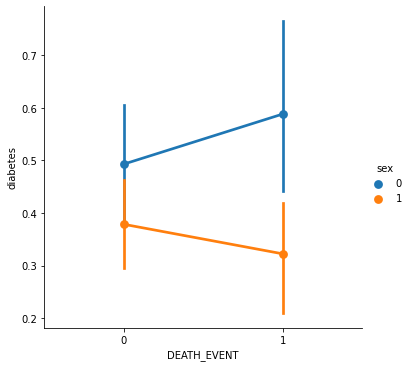

In [ ]:
sns.factorplot("DEATH_EVENT","diabetes",hue="sex", data=data)

In [ ]:
#target(hedef değişkeni) veri setinden ayırdık
y=data['DEATH_EVENT']
data=data.drop('DEATH_EVENT', axis=1)


In [ ]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: DEATH_EVENT, dtype: int64

In [ ]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 28.2 KB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


In [ ]:
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


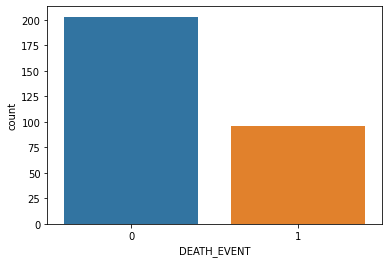

In [ ]:
sns.countplot(y)

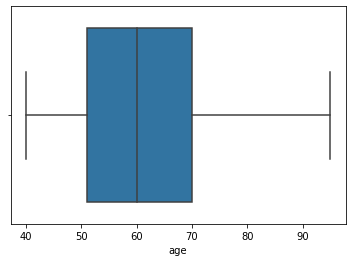

In [ ]:
sns.boxplot(x = data["age"]);

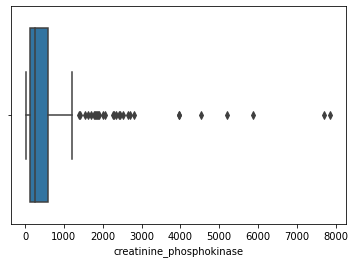

In [ ]:
#Çok fazla aykırı değere sahip olduğunu söyleyebiliriz. Gözlem sayımız az olduğu için aykırı değerlere baskılama yöntemi uygulanabilir.
sns.boxplot(x = data["creatinine_phosphokinase"]);

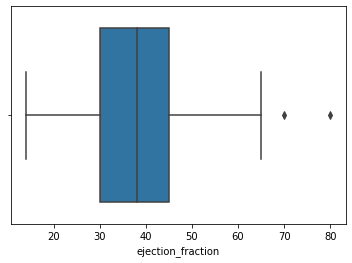

In [ ]:
sns.boxplot(x = data["ejection_fraction"]);

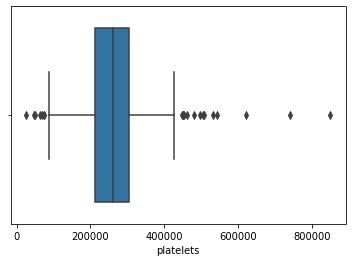

In [ ]:
#Çok fazla aykırı değere sahip olduğunu söyleyebiliriz. Gözlem sayımız az olduğu için aykırı değerlere baskılama yöntemi uygulanabilir.

sns.boxplot(x = data["platelets"]);

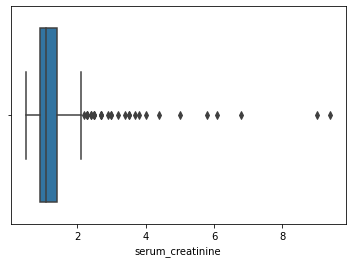

In [ ]:
#Çok fazla aykırı değere sahip olduğunu söyleyebiliriz. Gözlem sayımız az olduğu için aykırı değerlere baskılama yöntemi uygulanabilir.

sns.boxplot(x = data["serum_creatinine"]);

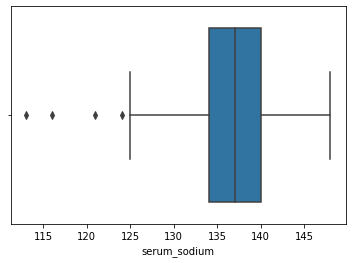

In [ ]:
sns.boxplot(x = data["serum_sodium"]);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


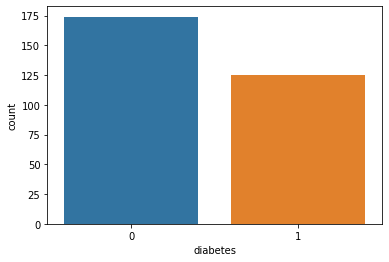

In [ ]:
sns.countplot('diabetes',data=data);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


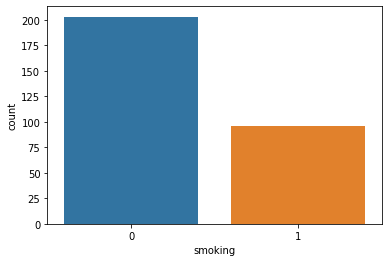

In [ ]:
sns.countplot('smoking',data=data);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


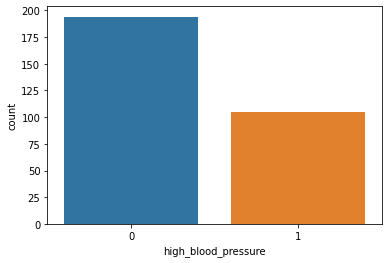

In [ ]:
sns.countplot('high_blood_pressure',data=data);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


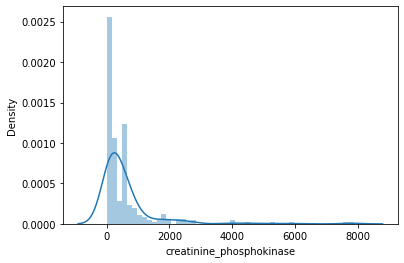

In [ ]:
sns.distplot(data.creatinine_phosphokinase);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


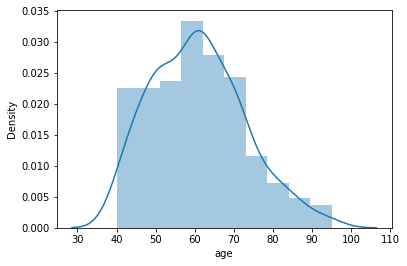

In [ ]:
sns.distplot(data.age);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


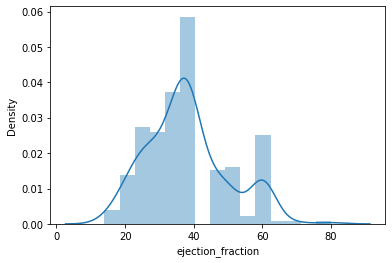

In [ ]:
#değişkenin iki farklı dağılımdan geldiğini incelenmesi gerektiğini söyleyebiliriz.
sns.distplot(data.ejection_fraction);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


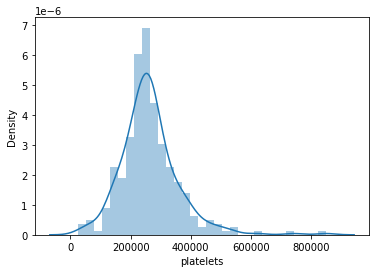

In [ ]:
#değişkenin normal dağıldığı söylenebilir
sns.distplot(data.platelets)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


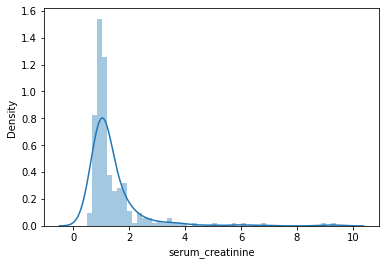

In [ ]:
#değişkenin normal dağıldığı söylenebilir
sns.distplot(data.serum_creatinine);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


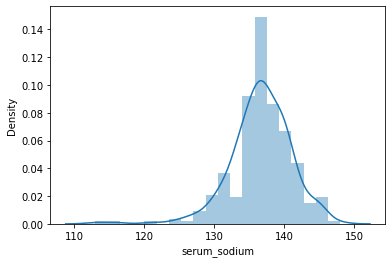

In [ ]:
#değişkenin normal dağıldığı söylenebilir
sns.distplot(data.serum_sodium);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


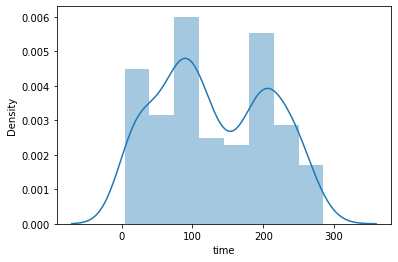

In [ ]:
sns.distplot(data.time)

In [ ]:
#sns.pairplot(data);

In [ ]:
#KORELASYON İNCELEMESİ

In [ ]:
data.corr()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
age,1.000000,-0.081584,0.060098,-0.052354,0.159187,-0.045966,-0.224068
creatinine_phosphokinase,-0.081584,1.000000,-0.044080,0.024463,-0.016408,0.059550,-0.009346
ejection_fraction,0.060098,-0.044080,1.000000,0.072177,-0.011302,0.175902,0.041729
platelets,-0.052354,0.024463,0.072177,1.000000,-0.041198,0.062125,0.010514
serum_creatinine,0.159187,-0.016408,-0.011302,-0.041198,1.000000,-0.189095,-0.149315
serum_sodium,-0.045966,0.059550,0.175902,0.062125,-0.189095,1.000000,0.087640
time,-0.224068,-0.009346,0.041729,0.010514,-0.149315,0.087640,1.000000


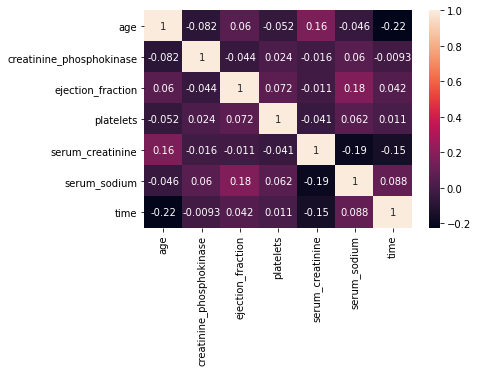

In [ ]:
sns.heatmap(data.corr(), annot = True)
# Tüm deişkenlerin birbiriyle çok az ilişkili olduğu korelasyon elemesi yapmamıza gerek olmadığı yorumunu yapabiliriz.

In [ ]:
# Datasetinin Train-Test ayrımı

In [ ]:
X=data

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train,X_test,y_train,y_test=train_test_split(data,y,test_size=0.33, random_state=42)
print("X_train", X_train.shape)

print("y_train",y_train.shape)

print("X_test",X_test.shape)

print("y_test",y_test.shape)

X_train (200, 12)
y_train (200,)
X_test (99, 12)
y_test (99,)


In [ ]:
Aşama 1
Değişkenlerde dönüşüm ve değişim yapmadan bazı makina öğrenmesi algoritmalarının uygulanması.

In [ ]:
# LOJİSTİK REGRESYON


In [ ]:
loj= sm.Logit(y_train,X_train)
loj_model=loj.fit()
loj_model.summary()
# model parametrelerinin anlamlılığı kontrol edildiğinde model için anlamlı olan parametreler:
# age,ejection_fraction, serum_creatinine ve time olarak belirlenebilir.

Optimization terminated successfully.
         Current function value: 0.320654
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            DEATH_EVENT   No. Observations:                  200
Model:                          Logit   Df Residuals:                      188
Method:                           MLE   Df Model:                           11
Date:                Mon, 09 Nov 2020   Pseudo R-squ.:                  0.4502
Time:                        13:11:43   Log-Likelihood:                -64.131
converged:                       True   LL-Null:                       -116.65
Covariance Type:            nonrobust   LLR p-value:                 1.783e-17
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
age                          0.0591      0.021      2.768      0.006       0.017       0.101
anaemia                     -0.4810      0.506     -0.951      0.342      -1.473       0.511
creatinine_phosphokinase  7.603e-05      0.000      0.357      0.721      -0.000       0.000
diabetes                     0.2773      0.465      0.596      0.551      -0.635       1.189
ejection_fraction           -0.0791      0.022     -3.558      0.000      -0.123      -0.036
high_blood_pressure         -0.1713      0.477     -0.359      0.720      -1.107       0.764
platelets                -1.837e-06   2.42e-06     -0.759      0.448   -6.58e-06     2.9e-06
serum_creatinine             0.9280      0.230      4.042      0.000       0.478       1.378
serum_sodium                 0.0028      0.012      0.235      0.814      -0.021       0.027
sex                         -0.9519      0.531     -1.792      0.073      -1.993       0.089
smoking                      0.3836      0.576      0.666      0.505      -0.745       1.512
time                        -0.0224      0.004     -5.443      0.000      -0.030      -0.014
============================================================================================
"""

In [ ]:
# TÜM DEĞİŞKENLER KULLANILARAK UYGULANAN ALGORİTMALAR

In [ ]:
loj=LogisticRegression(solver='liblinear')
loj_model=loj.fit(X_train,y_train)
loj_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred=loj_model.predict(X_test)
accuracy_score(y_test,loj_model.predict(X_test))

0.7575757575757576

In [ ]:
#Train data seti Lojistik Regresyon ile eğitildiğinde test data seti tahminleri hedef değişkenimizin '0'(Ölüm durumu olmama) kategorisi %82 , '1' (Ölüm durumu) ise %65 doğru tahmin edilmiştir.
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.93      0.82        57
           1       0.85      0.52      0.65        42

    accuracy                           0.76        99
   macro avg       0.79      0.73      0.73        99
weighted avg       0.78      0.76      0.74        99



In [ ]:
#10 farklı örneklem seçerek model doğruluk oranlarının ortalaması alındığında kurulan lojistik regresyon modelinde doğruluk oranımız %80'dir.
cross_val_score(loj_model,X_test,y_test,cv=10).mean()

0.8

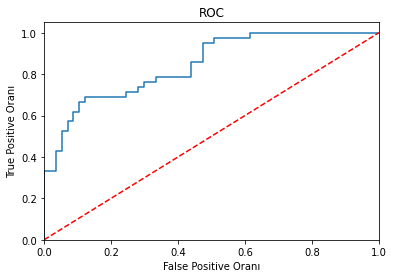

In [ ]:
logit_roc_auc = roc_auc_score(y_test, loj_model.predict(X_test))

fpr, tpr, thresholds = roc_curve(y_test, loj_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Oranı')
plt.ylabel('True Positive Oranı')
plt.title('ROC')
plt.show()

In [ ]:
#RANDOM FOREST ALGORİTMASI


In [ ]:
rf_model = RandomForestClassifier().fit(X_train, y_train)

In [ ]:
rf_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = rf_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7676767676767676

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.93      0.82        57
           1       0.85      0.55      0.67        42

    accuracy                           0.77        99
   macro avg       0.79      0.74      0.74        99
weighted avg       0.79      0.77      0.76        99



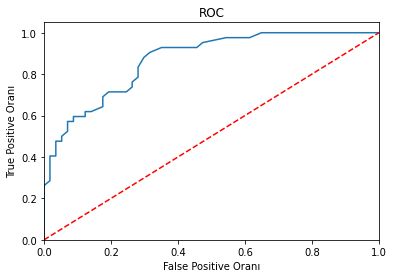

In [ ]:
logit_roc_auc = roc_auc_score(y_test, rf_model.predict(X_test))

fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Oranı')
plt.ylabel('True Positive Oranı')
plt.title('ROC')
plt.show()

In [ ]:
#Model Tuning

In [ ]:
rf_params = {"max_depth": [2,5,8,10],
            "max_features": [2,5,8],
            "n_estimators": [10,500,1000],
            "min_samples_split": [2,5,10]}

In [ ]:
rf_model = RandomForestClassifier()

rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 10, 
                           n_jobs = -1, 
                           verbose = 2) 

In [ ]:
rf_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 11.3min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [ ]:
print("En iyi parametreler: " + str(rf_cv_model.best_params_))

En iyi parametreler: {'max_depth': 8, 'max_features': 2, 'min_samples_split': 5, 'n_estimators': 500}


In [ ]:
rf_tuned = RandomForestClassifier(max_depth = 8, 
                                  max_features = 2, 
                                  min_samples_split = 5,
                                  n_estimators = 500)

rf_tuned.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = rf_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.7676767676767676

In [ ]:
Importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},
                         index = X_train.columns)

Text(0.5, 0, 'Değişken Önem Düzeyleri')

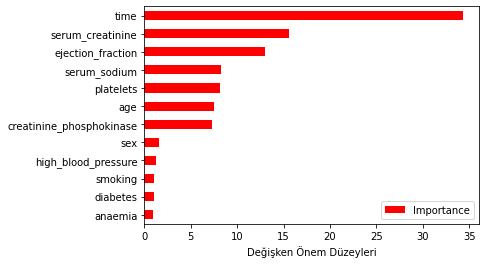

In [ ]:
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Değişken Önem Düzeyleri")

In [ ]:
# NEURAL NETWORK

In [ ]:
mlpc = MLPClassifier().fit(X_train, y_train)

In [ ]:
y_pred = mlpc.predict(X_test)
accuracy_score(y_test, y_pred)

0.5757575757575758

In [ ]:
#standart scaler uygulayalım

In [ ]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()

In [ ]:
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
mlpc_scaled = MLPClassifier().fit(X_train_scaled, y_train)

In [ ]:
y_pred = mlpc_scaled.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.7474747474747475

In [ ]:
# değişkenleri standartlaştırdığımızda accuracy oranımız yaklaşık %17 arttı

In [ ]:
# Model Tuning

In [ ]:
mlpc_params = {"alpha": [0.1, 0.01, 0.02, 0.005],
              "hidden_layer_sizes": [(10,10,10),
                              
                                     (100,100),
                                     (3,5), 
                                     (5, 3)],
              "solver" : ["lbfgs","adam","sgd"],
              "activation": ["relu","logistic"]}


In [ ]:
mlpc = MLPClassifier()
mlpc_cv_model = GridSearchCV(mlpc, mlpc_params, 
                         cv = 10, 
                         n_jobs = -1,
                         verbose = 2)

mlpc_cv_model.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  1.9min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_stat...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['re

In [ ]:
print("En iyi parametreler: " + str(mlpc_cv_model.best_params_))

En iyi parametreler: {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (10, 10, 10), 'solver': 'lbfgs'}


In [ ]:
mlp_tuned = MLPClassifier(alpha = 0.1, hidden_layer_sizes = (10,10,10), solver='lbfgs', activation='logistic')

In [ ]:
mlp_tuned.fit(X_train_scaled, y_train)

MLPClassifier(activation='logistic', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
y_pred = mlp_tuned.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.7474747474747475

In [ ]:
# CART 

In [ ]:
cart = DecisionTreeClassifier()
cart_model = cart.fit(X_train, y_train)

In [ ]:
y_pred = cart_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7070707070707071

In [ ]:
#Scale Data ile

In [ ]:
cart = DecisionTreeClassifier()
cart_scale_model = cart.fit(X_train_scaled, y_train)
y_pred = cart_model.predict(X_test_scaled)
accuracy_score(y_test, y_pred)


0.5757575757575758

In [ ]:
#Model Tuning


In [ ]:
?cart

In [ ]:
cart_grid = {"max_depth": range(1,10),
            "min_samples_split" : list(range(2,50)) }

In [ ]:
cart = tree.DecisionTreeClassifier()
cart_cv = GridSearchCV(cart, cart_grid, cv = 10, n_jobs = -1, verbose = 2)


In [ ]:
cart_cv_model = cart_cv.fit(X_train, y_train)
y_pred = cart_cv_model.predict(X_test)
accuracy_score(y_test, y_pred)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 4106 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:   14.2s finished


0.7676767676767676

In [ ]:
# GBM

In [ ]:
gbm_model = GradientBoostingClassifier().fit(X_train, y_train)

In [ ]:
y_pred = gbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7272727272727273

In [ ]:
#Scaled data

In [ ]:
gbm_model = GradientBoostingClassifier().fit(X_train_scaled, y_train)
y_pred = gbm_model.predict(X_test_scaled)
accuracy_score(y_test, y_pred)


0.7373737373737373

In [ ]:
#Model Tuning

In [ ]:
gbm_params = {"learning_rate" : [0.001, 0.01, 0.1, 0.05],
             "n_estimators": [100,500,100],
             "max_depth": [3,5,10],
             "min_samples_split": [2,5,10]}

In [ ]:
gbm = GradientBoostingClassifier()

gbm_cv = GridSearchCV(gbm, gbm_params, cv = 10, n_jobs = -1, verbose = 2)


In [ ]:
gbm_cv.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  3.4min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_...
                 

In [ ]:
print("En iyi parametreler: " + str(gbm_cv.best_params_))

En iyi parametreler: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 500}


In [ ]:
gbm = GradientBoostingClassifier(learning_rate = 0.01, 
                                 max_depth = 3,
                                min_samples_split = 2,
                                n_estimators = 500)

In [ ]:
gbm_tuned =  gbm.fit(X_train,y_train)

In [ ]:
y_pred = gbm_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.7373737373737373

In [ ]:
#Scaled data

In [ ]:
gbm_tuned =  gbm.fit(X_train_scaled,y_train)
y_pred = gbm_tuned.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.7474747474747475

In [ ]:
# XGB

In [ ]:
xgb_model = XGBClassifier().fit(X_train, y_train)

In [ ]:
y_pred = xgb_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7575757575757576

In [ ]:
#NAitive Bayes

In [ ]:
nb = GaussianNB()
nb_model = nb.fit(X_train, y_train)
nb_model

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
y_pred = nb_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.7575757575757576

In [ ]:
cross_val_score(nb_model, X_test, y_test, cv = 10).mean()

0.73

In [ ]:
#KNN


In [ ]:
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)
knn_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y_pred = knn_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.5555555555555556

In [ ]:
#scaled data

In [ ]:
knn_scaled_model = knn.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
accuracy_score(y_test,y_pred)

0.6464646464646465

In [ ]:
#tunıng

In [ ]:
knn_params = {"n_neighbors": np.arange(1,50)}

In [ ]:
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_params, cv=10)
knn_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
print("En iyi skor:" + str(knn_cv.best_score_))
print("En iyi parametreler: " + str(knn_cv.best_params_))

En iyi skor:0.765
En iyi parametreler: {'n_neighbors': 5}


In [ ]:
knn = KNeighborsClassifier(5)
knn_tuned = knn.fit(X_train_scaled, y_train)

In [ ]:
y_pred = knn_tuned.predict(X_test_scaled)
accuracy_score(y_test, y_pred)


0.6464646464646465

In [ ]:
# SVM


In [ ]:
svm_model = SVC(kernel = "linear").fit(X_train, y_train)

In [ ]:
y_pred = svm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.797979797979798

In [ ]:
#Scaled Data

In [ ]:
svm_model = SVC(kernel = "linear").fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.7676767676767676

In [ ]:
#Model Tuning

In [ ]:
svc_params = {"C": np.arange(1,10)}

svc = SVC(kernel = "linear")

svc_cv_model = GridSearchCV(svc,svc_params, 
                            cv = 10, 
                            n_jobs = -1, 
                            verbose = 2 )

svc_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 32.7min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [ ]:
print("En iyi parametreler: " + str(svc_cv_model.best_params_))

En iyi parametreler: {'C': 3}


In [ ]:
svc_tuned = SVC(kernel = "linear", C = 3).fit(X_train, y_train)

In [ ]:
y_pred = svc_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.7878787878787878

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=0)
dt_model = decision_tree.fit(X_train, y_train)
y_pred= dt_model.predict(X_test)
accuracy_score(y_test,y_pred)


0.696969696969697

In [ ]:
modeller = [
    knn_tuned,
    loj_model,
    svm_model,
    nb_model,
    mlp_tuned,
    cart_cv_model,
    rf_model,
    gbm_tuned,
    xgb_model,
    dt_model
    
]


for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test)
    dogruluk = accuracy_score(y_test, y_pred)
    print("-"*28)
    print(isimler + ":" )
    print("Accuracy: {:.4%}".format(dogruluk))

----------------------------
KNeighborsClassifier:
Accuracy: 57.5758%
----------------------------
LogisticRegression:
Accuracy: 75.7576%
----------------------------
SVC:
Accuracy: 79.7980%
----------------------------
GaussianNB:
Accuracy: 75.7576%
----------------------------
MLPClassifier:
Accuracy: 42.4242%
----------------------------
GridSearchCV:
Accuracy: 76.7677%
----------------------------
RandomForestClassifier:
Accuracy: 76.7677%
----------------------------
GradientBoostingClassifier:
Accuracy: 42.4242%
----------------------------
XGBClassifier:
Accuracy: 75.7576%
----------------------------
DecisionTreeClassifier:
Accuracy: 69.6970%


In [ ]:
# AŞAMA 2
# LOJİSTİK REGRESYONA GÖRE ANLAMSIZ ÇIKAN PARAMETRELERİN DATA SETİNDEN ÇIKARILMASI

In [ ]:
feature= data.drop(['age','ejection_fraction', 'serum_creatinine','time'], axis=1)
feature.head()

,anaemia,creatinine_phosphokinase,diabetes,high_blood_pressure,platelets,serum_sodium,sex,smoking
0,0,582,0,1,265000.00,130,1,0
1,0,7861,0,0,263358.03,136,1,0
2,0,146,0,0,162000.00,129,1,1
3,1,111,0,0,210000.00,137,1,0
4,1,160,1,0,327000.00,116,0,0


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train,X_test,y_train,y_test=train_test_split(feature,y,test_size=0.33, random_state=42)
print("X_train", X_train.shape)

print("y_train",y_train.shape)

print("X_test",X_test.shape)

print("y_test",y_test.shape)

X_train (200, 8)
y_train (200,)
X_test (99, 8)
y_test (99,)


In [ ]:
# Lojistik Regresyon

In [ ]:
#Tüm model parametrelerinin anlamlı olduğunu söyleyebiliriz.
loj= sm.Logit(y_train,X_train)
loj_model=loj.fit()
loj_model.summary()

Optimization terminated successfully.
         Current function value: 0.576377
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            DEATH_EVENT   No. Observations:                  200
Model:                          Logit   Df Residuals:                      192
Method:                           MLE   Df Model:                            7
Date:                Mon, 09 Nov 2020   Pseudo R-squ.:                 0.01180
Time:                        10:14:58   Log-Likelihood:                -115.28
converged:                       True   LL-Null:                       -116.65
Covariance Type:            nonrobust   LLR p-value:                    0.9069
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
anaemia                      0.0372      0.339      0.110      0.913      -0.627       0.702
creatinine_phosphokinase     0.0001      0.000      0.690      0.490      -0.000       0.000
diabetes                     0.0798      0.334      0.239      0.811      -0.575       0.734
high_blood_pressure          0.2950      0.334      0.884      0.377      -0.359       0.949
platelets                -7.071e-08   1.79e-06     -0.040      0.968   -3.57e-06    3.43e-06
serum_sodium                -0.0080      0.005     -1.680      0.093      -0.017       0.001
sex                         -0.1857      0.373     -0.497      0.619      -0.918       0.546
smoking                     -0.0398      0.401     -0.099      0.921      -0.825       0.745
============================================================================================
"""

In [ ]:
loj=LogisticRegression(solver='liblinear')
loj_model=loj.fit(X_train,y_train)
y_pred= loj_model.predict(X_test)
accuracy_score(y_test,y_pred)

0.5757575757575758

In [ ]:
# RANDOM FOREST

In [ ]:
rf_model = RandomForestClassifier().fit(X_train, y_train)

In [ ]:
y_pred= rf_model.predict(X_test)
accuracy_score(y_test,y_pred)

0.5656565656565656

In [ ]:
#SVC

In [ ]:
svm_model = SVC(kernel = "linear").fit(X_train, y_train)

In [ ]:
y_pred= svm_model.predict(X_test)
accuracy_score(y_test,y_pred)

0.5757575757575758

In [ ]:
#Gaussian NB

In [ ]:
nb = GaussianNB()
nb_model = nb.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.5757575757575758

In [ ]:
#DecisionTree

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=0)
dt_model = decision_tree.fit(X_train, y_train)
y_pred= dt_model.predict(X_test)
accuracy_score(y_test,y_pred)


0.6262626262626263

In [ ]:
#KNN

In [ ]:
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)
y_pred=knn_model.predict(X_test)
accuracy_score(y_test,y_pred)

0.5555555555555556

In [ ]:
#GBM

In [ ]:
gbm_model = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = gbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6060606060606061

In [ ]:
# Cart

In [ ]:
cart = DecisionTreeClassifier()
cart_model = cart.fit(X_train, y_train)
y_pred = cart_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6363636363636364

In [ ]:
#XGB

In [ ]:
xgb_model = XGBClassifier().fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6363636363636364

In [ ]:
modeller = [
    knn_model,
    loj_model,
    svm_model,
    nb_model,
    cart_model,
    rf_model,
    gbm_model,
    xgb_model,
    dt_model
    
]


for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test)
    dogruluk = accuracy_score(y_test, y_pred)
    print("-"*28)
    print(isimler + ":" )
    print("Accuracy: {:.4%}".format(dogruluk))

----------------------------
KNeighborsClassifier:
Accuracy: 55.5556%
----------------------------
LogisticRegression:
Accuracy: 57.5758%
----------------------------
SVC:
Accuracy: 57.5758%
----------------------------
GaussianNB:
Accuracy: 57.5758%
----------------------------
DecisionTreeClassifier:
Accuracy: 63.6364%
----------------------------
RandomForestClassifier:
Accuracy: 56.5657%
----------------------------
GradientBoostingClassifier:
Accuracy: 60.6061%
----------------------------
XGBClassifier:
Accuracy: 63.6364%
----------------------------
DecisionTreeClassifier:
Accuracy: 62.6263%
